# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

![Screenshot 2025-09-05 at 2.35.41 AM.png](attachment:e5ef4b19-0f9d-4ae0-8594-7a20446428b7.png)

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance.

Finally, you will consider all that you have learned and build your best model and run it on the test set.


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework.


In [122]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [123]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples.

In [124]:



# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_cat` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [125]:
# Your code here

random_seed = 42


y_labels = y_sub

# 1) Stratified train/test split (keep class proportions the same)

X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_labels, test_size=0.2, stratify=y_labels, random_state=random_seed
)

# 2) Standardize features (learn on train, apply to test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit on training data only
X_test_scaled = scaler.transform(X_test)         # apply same scaling to test




### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1773 - loss: 1.9711 - val_accuracy: 0.4711 - val_loss: 1.5420
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5056 - loss: 1.4330 - val_accuracy: 0.5993 - val_loss: 1.1562
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6054 - loss: 1.0992 - val_accuracy: 0.6316 - val_loss: 0.9661
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6325 - loss: 0.9508 - val_accuracy: 0.6521 - val_loss: 0.8857
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6453 - loss: 0.8842 - val_accuracy: 0.6661 - val_loss: 0.8407
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6568 - loss: 0.8442 - val_accuracy: 0.6781 - val_loss: 0.8103
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6663 - loss: 0.8159 - val_accuracy: 0.6885 - val_loss: 0.7873
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6772 - loss: 0.7936 - val_accuracy: 0.

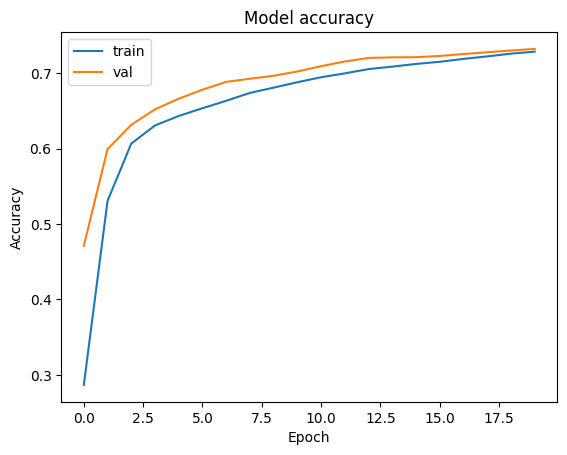

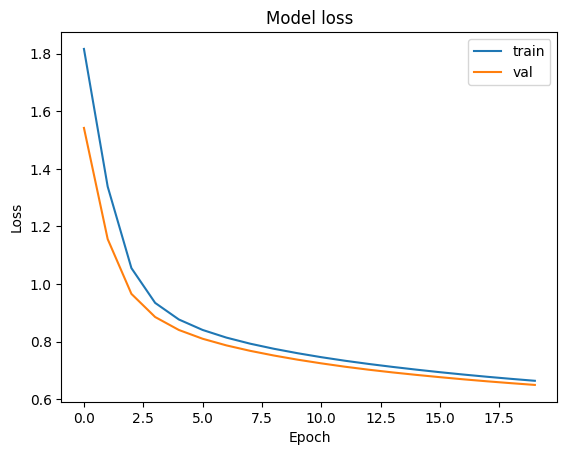

In [126]:
# Your code here


# Make results repeatable
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Get sizes (you already printed these before)
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

# 1) Build the model: input -> 64 -> 32 -> output
model = models.Sequential([
    layers.Input(shape=(num_features,)),    # 1D array with length = number of features
    layers.Dense(64, activation='relu'),    # hidden layer with 64 neurons
    layers.Dense(32, activation='relu'),    # hidden layer with 32 neurons
    layers.Dense(num_classes, activation='softmax')  # output probabilities for each class
])

# Show model layout
model.summary()

# 2) Compile the model (set optimizer, loss, metrics)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',   # use this when labels are integers like 0,1,2...
    metrics=['accuracy']
)

# 3) Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

print(history.history['accuracy'])

final_accuracy = history.history['accuracy'][-1]   # -1 = last item in the list
print("Final training accuracy:", final_accuracy)

# 4) Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, batch_size=32, verbose=1)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# 5) Plot training curves (accuracy and loss)
def plot_history(history):
    # Accuracy plot
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.show()

plot_history(history)


In [127]:
# Set a1a to the final training accuracy at epoch 20

a1a = final_accuracy             # Replace 0.0 with your answer

In [128]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.7286


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


======== Training with batch_size = 4 ========
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4173 - loss: 1.5546 - val_accuracy: 0.6391 - val_loss: 0.9292
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6441 - loss: 0.8999 - val_accuracy: 0.6825 - val_loss: 0.7999
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6805 - loss: 0.8016 - val_accuracy: 0.7041 - val_loss: 0.7464
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6981 - loss: 0.7537 - val_accuracy: 0.7140 - val_loss: 0.7108
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7086 - loss: 0.7200 - val_accuracy: 0.7262 - val_loss: 0.6844
Epoch 6/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7186 - loss: 0.6943 - val_accuracy: 0.7293 - val_loss: 0.6637
Epoch 7/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7276 - loss: 0.6732 - val_accuracy: 0.7340 - val_loss: 0.6467
Epoch 8/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━

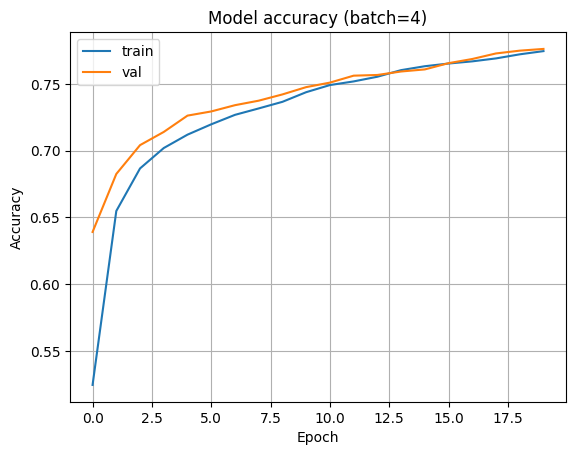

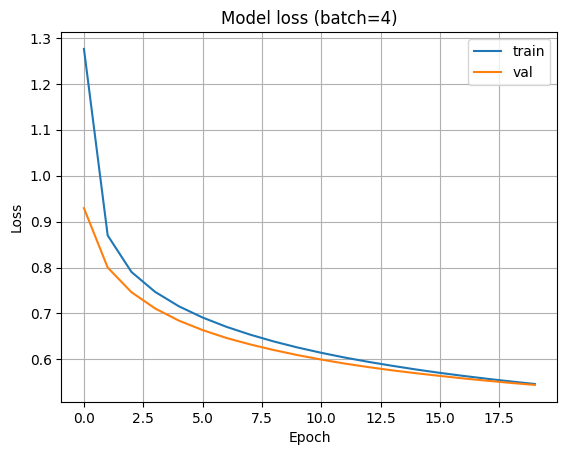


======== Training with batch_size = 8 ========
Epoch 1/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3357 - loss: 1.7659 - val_accuracy: 0.6110 - val_loss: 1.0636
Epoch 2/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6186 - loss: 1.0002 - val_accuracy: 0.6674 - val_loss: 0.8473
Epoch 3/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6650 - loss: 0.8462 - val_accuracy: 0.6906 - val_loss: 0.7804
Epoch 4/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6886 - loss: 0.7876 - val_accuracy: 0.7041 - val_loss: 0.7417
Epoch 5/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7002 - loss: 0.7513 - val_accuracy: 0.7163 - val_loss: 0.7143
Epoch 6/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7103 - loss: 0.7250 - val_accuracy: 0.7231 - val_loss: 0.6932
Epoch 7/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7164 - loss: 0.7039 - val_accuracy: 0.7309 - val_loss: 0.6759
Epoch 8/20
1923/1923 ━━━━━━━━━━━━━━━━━━━━ 

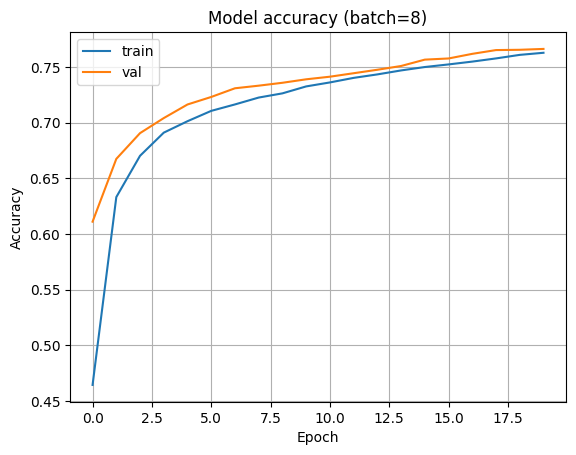

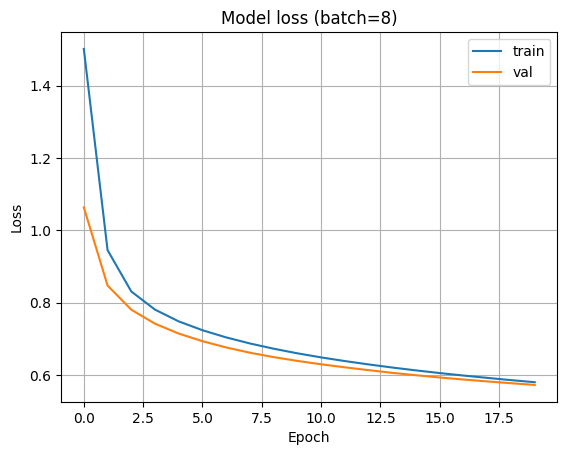


======== Training with batch_size = 16 ========
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2624 - loss: 1.8520 - val_accuracy: 0.5458 - val_loss: 1.3107
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5638 - loss: 1.1963 - val_accuracy: 0.6173 - val_loss: 0.9861
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6171 - loss: 0.9537 - val_accuracy: 0.6451 - val_loss: 0.8772
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6440 - loss: 0.8673 - val_accuracy: 0.6781 - val_loss: 0.8215
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6708 - loss: 0.8206 - val_accuracy: 0.6898 - val_loss: 0.7849
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6836 - loss: 0.7886 - val_accuracy: 0.7038 - val_loss: 0.7584
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6931 - loss: 0.7639 - val_accuracy: 0.7106 - val_loss: 0.7372
Epoch 8/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - a

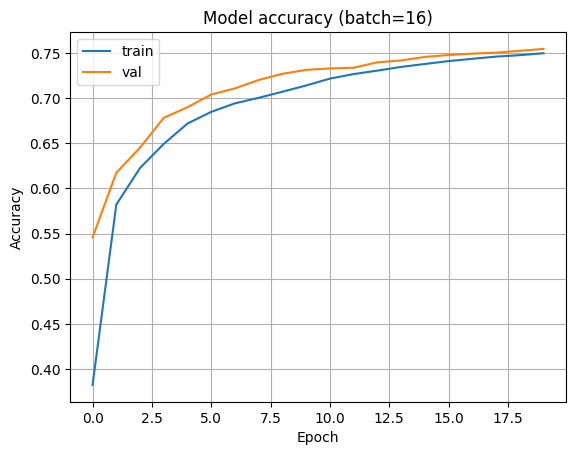

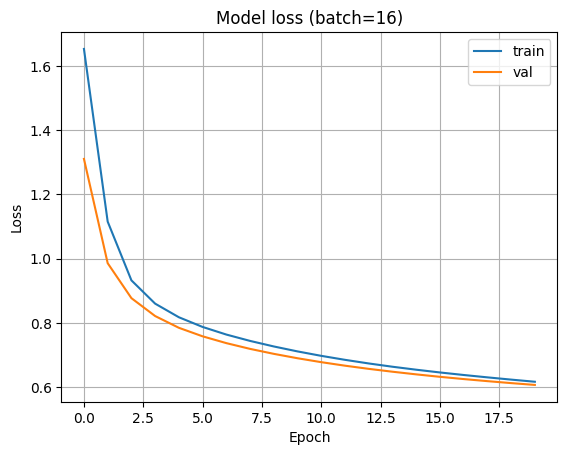


======== Training with batch_size = 128 ========
Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1463 - loss: 2.2321 - val_accuracy: 0.2119 - val_loss: 1.9785
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2397 - loss: 1.9099 - val_accuracy: 0.3820 - val_loss: 1.7225
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3992 - loss: 1.6631 - val_accuracy: 0.5078 - val_loss: 1.5036
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5037 - loss: 1.4557 - val_accuracy: 0.5634 - val_loss: 1.3254
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5607 - loss: 1.2911 - val_accuracy: 0.5920 - val_loss: 1.1925
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5853 - loss: 1.1701 - val_accuracy: 0.6087 - val_loss: 1.0968
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5986 - loss: 1.0827 - val_accuracy: 0.6160 - val_loss: 1.0270
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

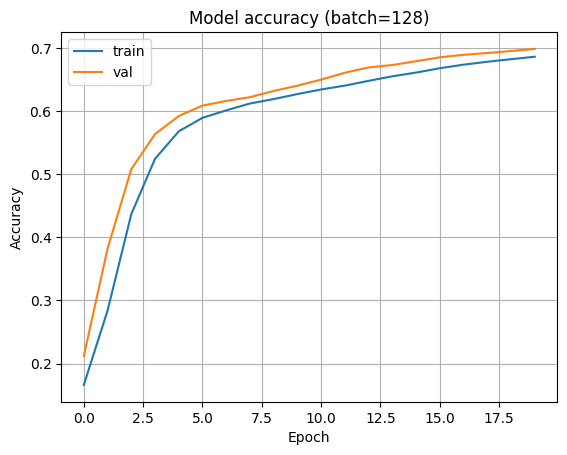

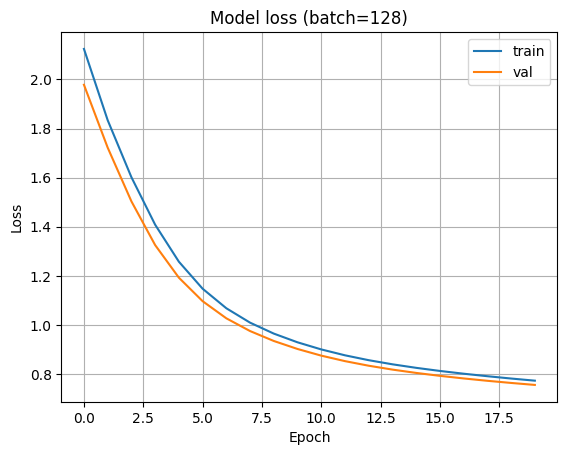


Summary of runs:
   batch_size  final_train_acc  final_val_acc  best_val_acc  epoch_best_val  \
0           4         0.774491       0.776131      0.776131              20   
1           8         0.762790       0.766251      0.766251              20   
2          16         0.749529       0.754290      0.754290              20   
3         128         0.686017       0.698388      0.698388              20   

   time_seconds  
0    182.446180  
1    120.008981  
2     62.632418  
3     11.459519  


In [129]:
# Your code here
# Problem Two: Batch Sizes -- run 4 experiments and plot results

import time


# model builder function (builds a fresh model each time)
def build_model():
    # re-seed before building to make initial weights comparable across runs
    tf.random.set_seed(random_seed)
    model = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# plotting helper (draws accuracy and loss)
def plot_history(history, title=None):
    if title is None:
        title = ""
    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

# experiment loop
batch_sizes = [4, 8, 16, 128]
results = []         # will hold summary rows
histories = {}       # store each history if you want to inspect later

for bs in batch_sizes:
    print("\n" + "="*8 + f" Training with batch_size = {bs} " + "="*8)
    model = build_model()   # fresh model
    start_time = time.time()
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,
        batch_size=bs,
        verbose=1
    )
    elapsed = time.time() - start_time

    histories[bs] = history

    # collect simple summary numbers
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    epoch_best_val = int(np.argmax(history.history['val_accuracy'])) + 1

    results.append({
        'batch_size': bs,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'best_val_acc': best_val_acc,
        'epoch_best_val': epoch_best_val,
        'time_seconds': elapsed
    })

    # plot curves for this run
    plot_history(history, title=f"(batch={bs})")

# show comparison table
summary_df = pd.DataFrame(results).sort_values('batch_size')
print("\nSummary of runs:")
print(summary_df)



# optionally save summary to a file for submission
summary_df.to_csv('batch_size_summary.tsv', sep='\t', index=False)


In [130]:
summary_df = pd.DataFrame(results)   # results is the list created in the experiment loop
# find the row with the largest final validation accuracy (at epoch 20)
best_row = summary_df.loc[summary_df['final_val_acc'].idxmax()]

In [131]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = int(best_row['batch_size'])             # Replace 0 with your answer

In [132]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a}')

a2a = 4


In [133]:
# Set a2b to the best accuracy score found

a2b = float(best_row['final_val_acc'])             # Replace 0.0 with your answer

In [134]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2b = {a2b:.4f}')

a2b = 0.7761


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



======== Training with lr = 0.001 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2711 - loss: 1.9371 - val_accuracy: 0.5073 - val_loss: 1.4948
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5372 - loss: 1.3687 - val_accuracy: 0.6022 - val_loss: 1.1181
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6090 - loss: 1.0634 - val_accuracy: 0.6295 - val_loss: 0.9556
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6399 - loss: 0.9349 - val_accuracy: 0.6570 - val_loss: 0.8762
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6594 - loss: 0.8717 - val_accuracy: 0.6732 - val_loss: 0.8321
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6711 - loss: 0.8343 - val_accuracy: 0.6849 - val_loss: 0.8021
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6801 - loss: 0.8073 - val_accuracy: 0.6911 - val_loss: 0.7798
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accura

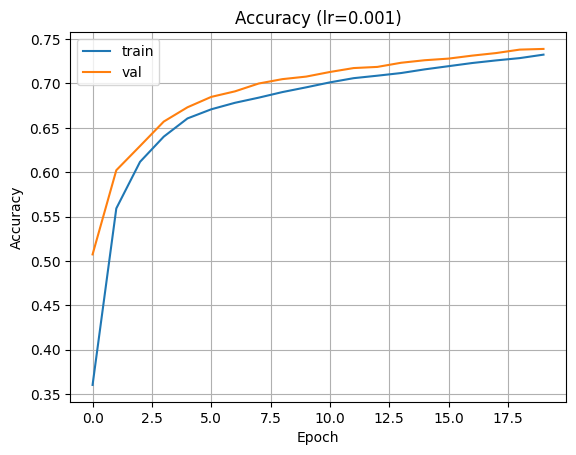

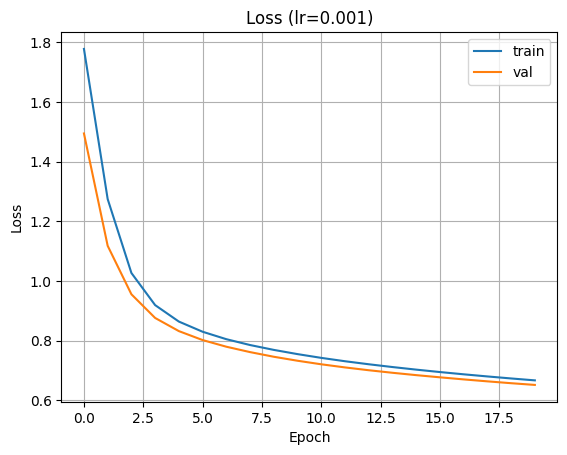


======== Training with lr = 0.0005 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2247 - loss: 1.9021 - val_accuracy: 0.4880 - val_loss: 1.4783
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5267 - loss: 1.3633 - val_accuracy: 0.5991 - val_loss: 1.1023
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6042 - loss: 1.0604 - val_accuracy: 0.6417 - val_loss: 0.9530
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6314 - loss: 0.9457 - val_accuracy: 0.6594 - val_loss: 0.8848
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6443 - loss: 0.8895 - val_accuracy: 0.6729 - val_loss: 0.8427
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6587 - loss: 0.8520 - val_accuracy: 0.6843 - val_loss: 0.8129
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6679 - loss: 0.8232 - val_accuracy: 0.6895 - val_loss: 0.7899
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accur

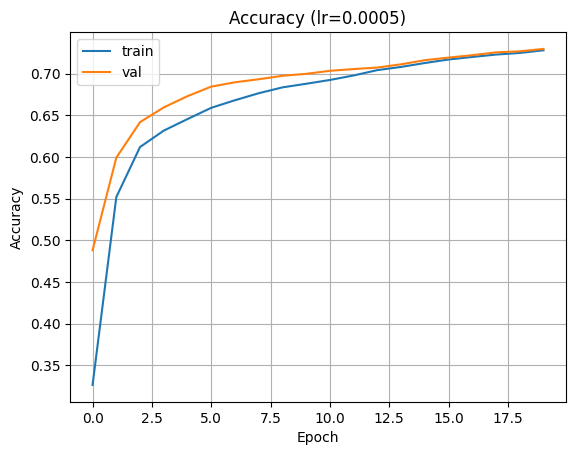

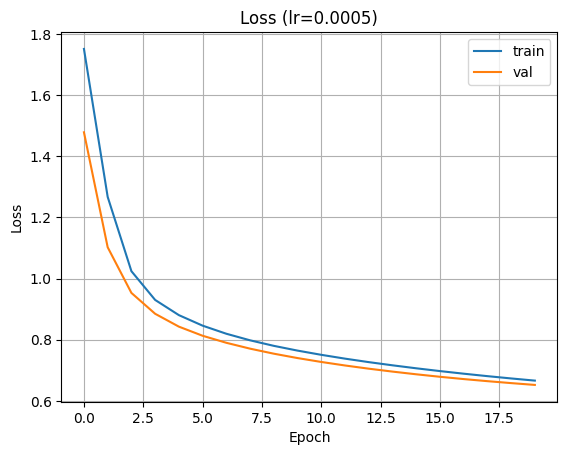


======== Training with lr = 0.0001 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2066 - loss: 1.9979 - val_accuracy: 0.4454 - val_loss: 1.5543
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4847 - loss: 1.4234 - val_accuracy: 0.5770 - val_loss: 1.1502
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5912 - loss: 1.0890 - val_accuracy: 0.6256 - val_loss: 0.9782
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6271 - loss: 0.9542 - val_accuracy: 0.6474 - val_loss: 0.8997
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6476 - loss: 0.8903 - val_accuracy: 0.6651 - val_loss: 0.8500
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6669 - loss: 0.8483 - val_accuracy: 0.6843 - val_loss: 0.8130
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6812 - loss: 0.8164 - val_accuracy: 0.6958 - val_loss: 0.7838
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accur

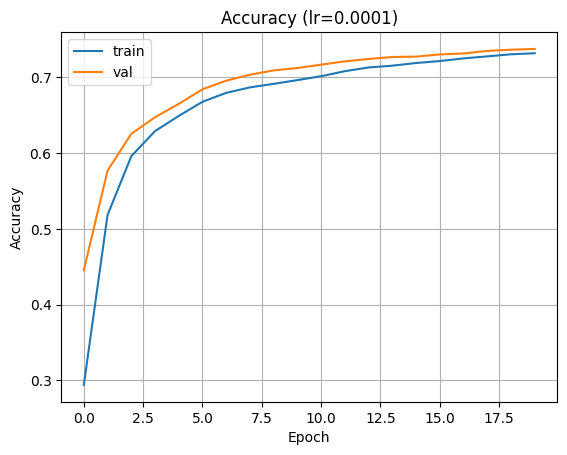

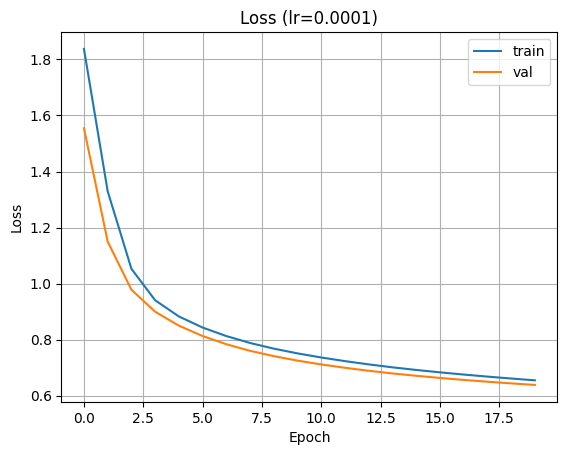


======== Training with lr = 5e-05 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2108 - loss: 1.9405 - val_accuracy: 0.5250 - val_loss: 1.4180
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5385 - loss: 1.3242 - val_accuracy: 0.5996 - val_loss: 1.0755
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5997 - loss: 1.0474 - val_accuracy: 0.6331 - val_loss: 0.9354
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6273 - loss: 0.9307 - val_accuracy: 0.6560 - val_loss: 0.8687
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6448 - loss: 0.8714 - val_accuracy: 0.6693 - val_loss: 0.8301
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6557 - loss: 0.8360 - val_accuracy: 0.6752 - val_loss: 0.8037
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6650 - loss: 0.8112 - val_accuracy: 0.6846 - val_loss: 0.7836
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accura

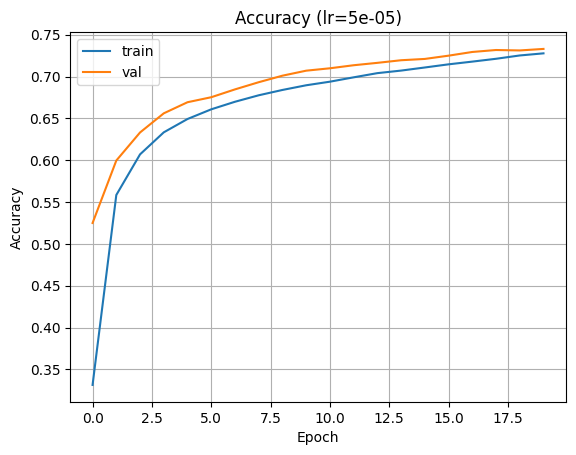

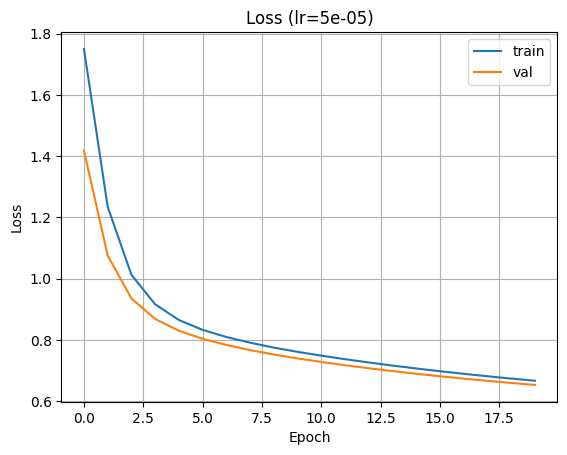


======== Training with lr = 1e-05 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2649 - loss: 1.9278 - val_accuracy: 0.4899 - val_loss: 1.4749
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5207 - loss: 1.3711 - val_accuracy: 0.5827 - val_loss: 1.1352
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5897 - loss: 1.0902 - val_accuracy: 0.6243 - val_loss: 0.9772
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6140 - loss: 0.9634 - val_accuracy: 0.6420 - val_loss: 0.8985
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6342 - loss: 0.8983 - val_accuracy: 0.6607 - val_loss: 0.8511
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6459 - loss: 0.8573 - val_accuracy: 0.6742 - val_loss: 0.8178
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6600 - loss: 0.8269 - val_accuracy: 0.6799 - val_loss: 0.7921
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accura

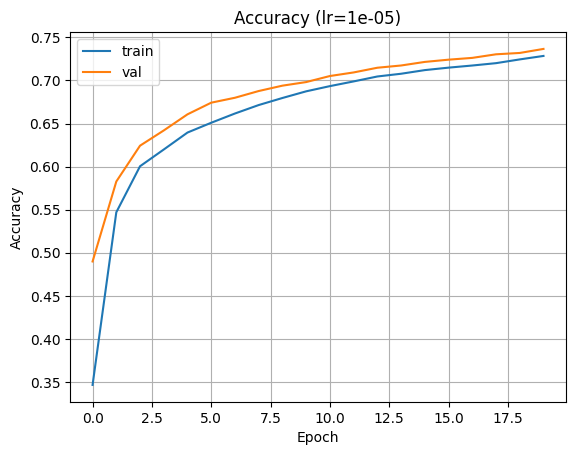

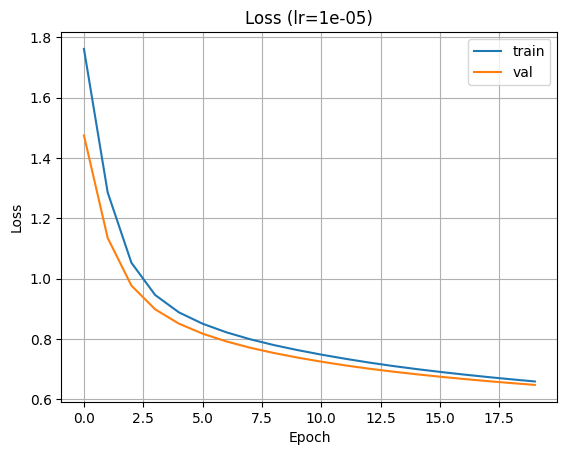


Summary of learning-rate runs:
   learning_rate  final_train_acc  final_val_acc  best_val_acc  \
0        0.00100         0.732497       0.738950      0.738950   
1        0.00050         0.727946       0.729589      0.729589   
2        0.00010         0.731977       0.737650      0.737650   
3        0.00005         0.727686       0.732969      0.732969   
4        0.00001         0.728467       0.736609      0.736609   

   epoch_best_val  time_seconds  
0              20     31.250092  
1              20     33.554896  
2              20     31.225770  
3              20     35.490649  
4              20     39.024448  


In [136]:
# Your code here
# Model builder that accepts a learning rate
def build_model(lr):
    # clear previous models and set seed so starts are comparable
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)
    model = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Simple plotting helper (train vs val)
def plot_history(history, title=None):
    if title is None:
        title = ""
    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Accuracy {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

# Learning rates to test
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results = []
histories = {}

for lr in learning_rates:
    print("\n" + "="*8 + f" Training with lr = {lr} " + "="*8)
    model = build_model(lr)
    start_time = time.time()
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,
        batch_size=32,
        verbose=1
    )
    elapsed = time.time() - start_time

    histories[lr] = history

    final_train_acc = history.history['accuracy'][-1]    # training acc at epoch 20
    final_val_acc = history.history['val_accuracy'][-1]  # validation acc at epoch 20
    best_val_acc = max(history.history['val_accuracy'])  # best val acc during training
    epoch_best_val = int(np.argmax(history.history['val_accuracy'])) + 1

    results.append({
        'learning_rate': lr,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'best_val_acc': best_val_acc,
        'epoch_best_val': epoch_best_val,
        'time_seconds': elapsed
    })

    # show plots for this learning rate
    plot_history(history, title=f"(lr={lr})")

# Summary table
learning_rates_summary_df = pd.DataFrame(results).sort_values('learning_rate', ascending=False)
print("\nSummary of learning-rate runs:")
print(learning_rates_summary_df)

# Choose best by final validation accuracy at epoch 20
best_row = learning_rates_summary_df.loc[learning_rates_summary_df['final_val_acc'].idxmax()]


In [137]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = float(best_row['learning_rate'])              # Replace 0.0 with your answer

In [138]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3a = {a3a:.4f}')

a3a = 0.0010


In [139]:
# Set a3b to the accuracy found by the best learning rate

a3b = float(best_row['final_val_acc'])             # Replace 0.0 with your answer

In [140]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a3b = {a3b:.4f}')

a3b = 0.7389


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam.

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


======== Training with initial lr = 0.01 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2902 - loss: 1.8804 - val_accuracy: 0.4964 - val_loss: 1.4612
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5195 - loss: 1.3739 - val_accuracy: 0.5915 - val_loss: 1.1283
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5909 - loss: 1.0865 - val_accuracy: 0.6305 - val_loss: 0.9631
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6296 - loss: 0.9475 - val_accuracy: 0.6544 - val_loss: 0.8830
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6447 - loss: 0.8804 - val_accuracy: 0.6638 - val_loss: 0.8377
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6573 - loss: 0.8408 - val_accuracy: 0.6784 - val_loss: 0.8076
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6704 - loss: 0.8129 - val_accuracy: 0.6856 - val_loss: 0.7845
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step -

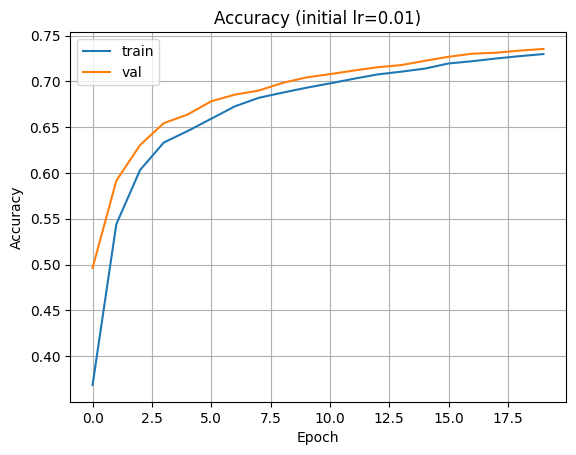

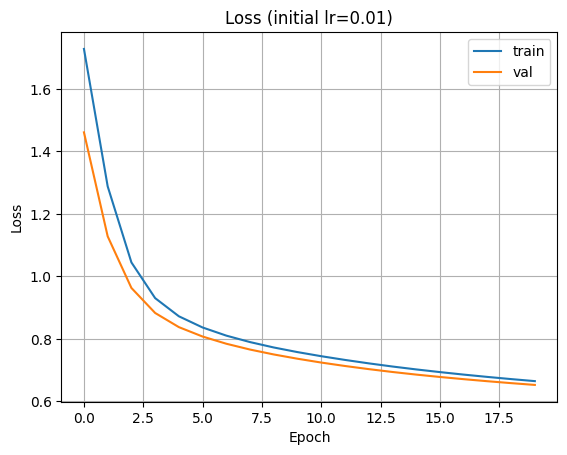


======== Training with initial lr = 0.005 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2346 - loss: 2.0247 - val_accuracy: 0.4503 - val_loss: 1.5817
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4948 - loss: 1.4796 - val_accuracy: 0.5736 - val_loss: 1.2280
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5792 - loss: 1.1679 - val_accuracy: 0.6201 - val_loss: 1.0278
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6165 - loss: 1.0001 - val_accuracy: 0.6477 - val_loss: 0.9226
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6386 - loss: 0.9137 - val_accuracy: 0.6589 - val_loss: 0.8611
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6526 - loss: 0.8622 - val_accuracy: 0.6729 - val_loss: 0.8217
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6641 - loss: 0.8282 - val_accuracy: 0.6867 - val_loss: 0.7941
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 

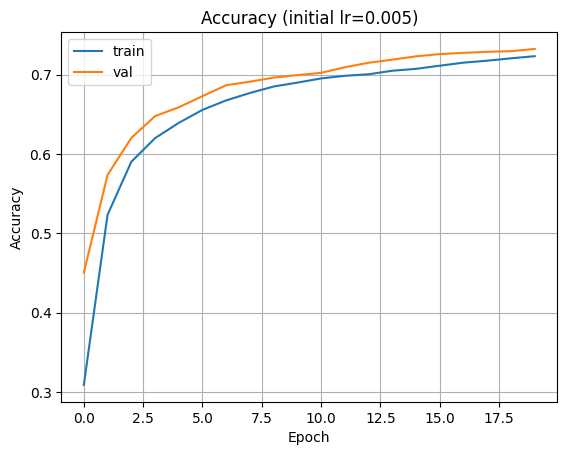

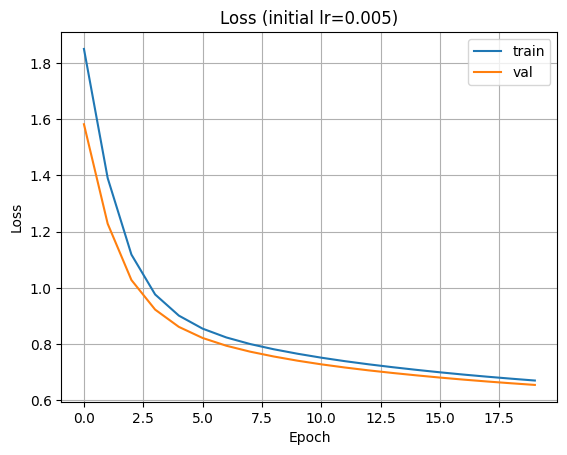


======== Training with initial lr = 0.001 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2954 - loss: 1.8313 - val_accuracy: 0.5088 - val_loss: 1.3836
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5188 - loss: 1.2802 - val_accuracy: 0.5861 - val_loss: 1.0744
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5846 - loss: 1.0369 - val_accuracy: 0.6305 - val_loss: 0.9404
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6239 - loss: 0.9284 - val_accuracy: 0.6503 - val_loss: 0.8676
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6466 - loss: 0.8678 - val_accuracy: 0.6703 - val_loss: 0.8218
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6647 - loss: 0.8291 - val_accuracy: 0.6810 - val_loss: 0.7899
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6741 - loss: 0.8013 - val_accuracy: 0.6882 - val_loss: 0.7656
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 

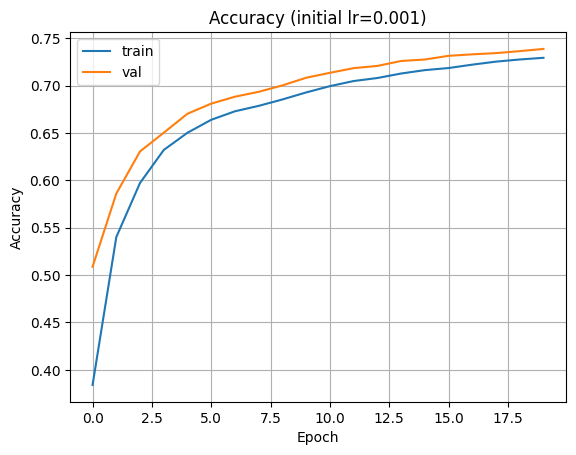

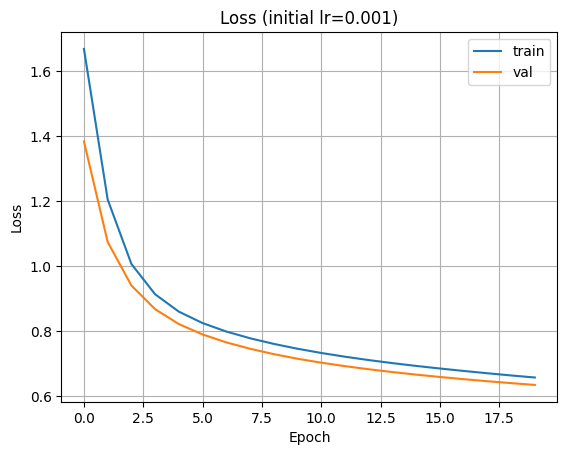


======== Training with initial lr = 0.0005 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2008 - loss: 1.9414 - val_accuracy: 0.4984 - val_loss: 1.4916
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5312 - loss: 1.3871 - val_accuracy: 0.5978 - val_loss: 1.1208
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6022 - loss: 1.0827 - val_accuracy: 0.6282 - val_loss: 0.9634
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6213 - loss: 0.9555 - val_accuracy: 0.6516 - val_loss: 0.8880
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6470 - loss: 0.8916 - val_accuracy: 0.6661 - val_loss: 0.8427
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6633 - loss: 0.8508 - val_accuracy: 0.6713 - val_loss: 0.8103
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6747 - loss: 0.8207 - val_accuracy: 0.6833 - val_loss: 0.7853
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

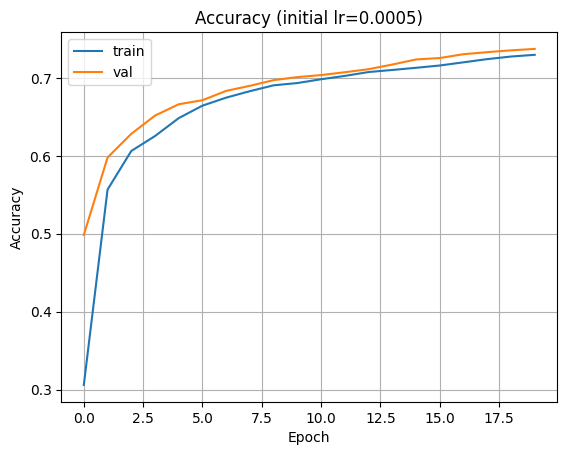

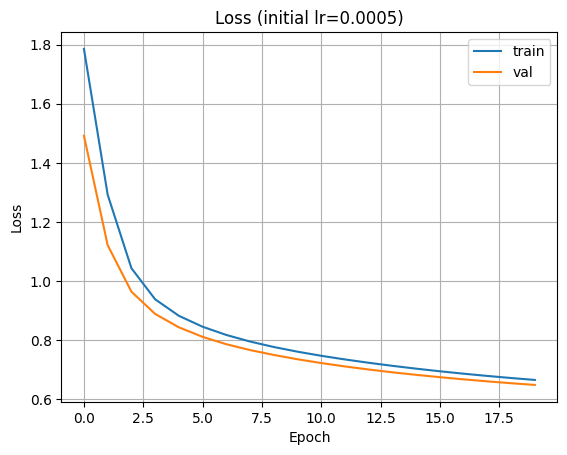


======== Training with initial lr = 0.0001 ========
Epoch 1/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2034 - loss: 1.9255 - val_accuracy: 0.4730 - val_loss: 1.5151
Epoch 2/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5114 - loss: 1.4135 - val_accuracy: 0.5897 - val_loss: 1.1467
Epoch 3/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6010 - loss: 1.0903 - val_accuracy: 0.6271 - val_loss: 0.9564
Epoch 4/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6244 - loss: 0.9397 - val_accuracy: 0.6537 - val_loss: 0.8740
Epoch 5/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6456 - loss: 0.8713 - val_accuracy: 0.6755 - val_loss: 0.8286
Epoch 6/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6645 - loss: 0.8313 - val_accuracy: 0.6843 - val_loss: 0.7980
Epoch 7/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6748 - loss: 0.8034 - val_accuracy: 0.6940 - val_loss: 0.7754
Epoch 8/20
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

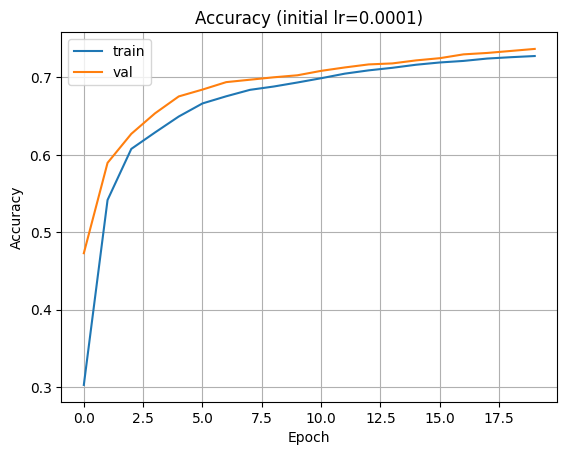

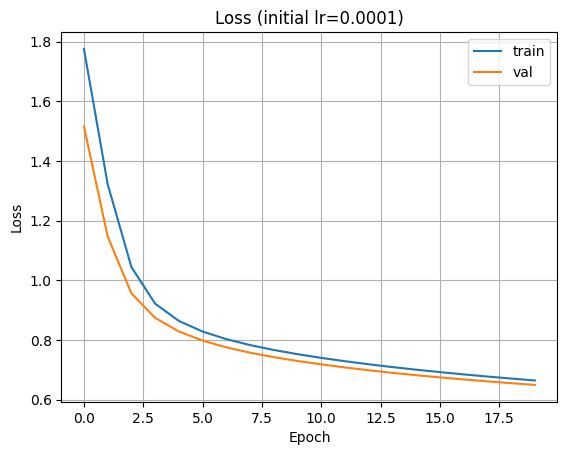


Summary of Cosine Decay runs:
   initial_lr  final_val_acc
0      0.0100       0.735569
1      0.0050       0.732449
2      0.0010       0.738690
3      0.0005       0.737130
4      0.0001       0.736869


In [141]:
# Your code here

# ---- model builder with Cosine Decay ----
def build_model_with_cosine(lr_init, batch_size, epochs):
    tf.keras.backend.clear_session()        # clear old models
    tf.random.set_seed(random_seed)

    steps_per_epoch = int(np.ceil(len(X_train_scaled) / batch_size))
    total_steps = epochs * steps_per_epoch

    # define Cosine Decay schedule
    lr_schedule = CosineDecay(
        initial_learning_rate=lr_init,
        decay_steps=total_steps,
        alpha=0.0   # final learning rate goes to 0
    )

    # build model
    model = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # compile with Adam using schedule
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---- plotting helper ----
def plot_history(history, title=None):
    if title is None:
        title = ""
    # Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Accuracy {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'val'])
    plt.grid(True)
    plt.show()

# ---- experiments ----
initial_lrs = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
batch_size = 32
epochs = 20

results = []
histories = {}

for lr in initial_lrs:
    print("\n" + "="*8 + f" Training with initial lr = {lr} " + "="*8)
    model = build_model_with_cosine(lr, batch_size, epochs)

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )

    histories[lr] = history

    final_val_acc = history.history['val_accuracy'][-1]
    results.append({
        'initial_lr': lr,
        'final_val_acc': final_val_acc
    })

    plot_history(history, title=f"(initial lr={lr})")

# ---- summary ----
import pandas as pd
cosine_summary = pd.DataFrame(results).sort_values('initial_lr', ascending=False)
print("\nSummary of Cosine Decay runs:")
print(cosine_summary)

# ---- best learning rate & accuracy ----
best_row = cosine_summary.loc[cosine_summary['final_val_acc'].idxmax()]


In [142]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = float(best_row['initial_lr'])             # Replace 0.0 with your answer

In [143]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4a = {a4a:.4f}')

a4a = 0.0010


In [144]:
# Set a4b to the best accuracy found

a4b = float(best_row['final_val_acc'])              # Replace 0.0 with your answer

In [145]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a4b = {a4b:.4f}')

a4b = 0.7387


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture.

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.

Chosen best row from experiments (top 1):
kind                batch
use_cosine          False
batch_size            4.0
initial_lr            NaN
final_val_acc    0.776131
Name: 0, dtype: object
Final hyperparameters -> batch_size=4, epochs=20, use_cosine=False, initial_lr=0.0001
No separate validation set found — using original training set for final training.
Epoch 1/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.3648 - loss: 1.6497 - val_accuracy: 0.6292 - val_loss: 0.9421
Epoch 2/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.6320 - loss: 0.9023 - val_accuracy: 0.6797 - val_loss: 0.7966
Epoch 3/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6766 - loss: 0.7922 - val_accuracy: 0.7051 - val_loss: 0.7375
Epoch 4/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6986 - loss: 0.7402 - val_accuracy: 0.7210 - val_loss: 0.7001
Epoch 5/20
3846/3846 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7099 - loss: 0.7050 - val_accuracy: 0.7275 - 

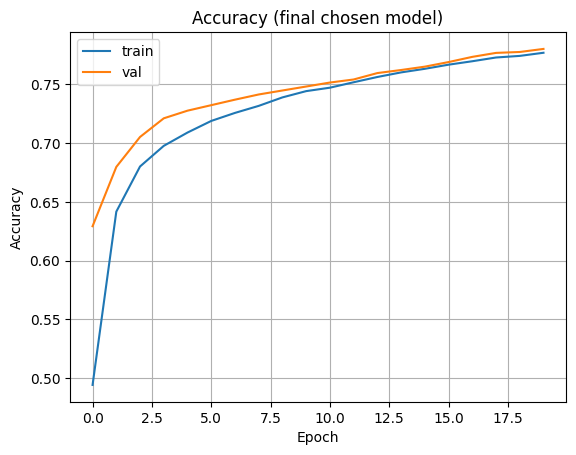

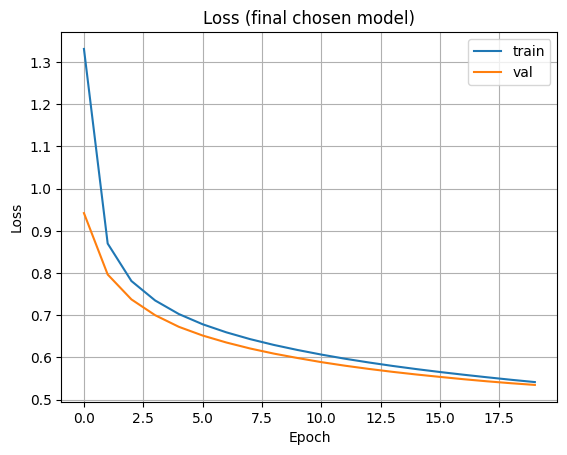

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7791 - loss: 0.5386
Final test loss: 0.5348, Final test accuracy: 0.7800


In [154]:

# Pick best run, retrain, evaluate

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
import matplotlib.pyplot as plt
import math

# reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# small plot helper (same as before)
def plot_history(history, title=None):
    if title is None:
        title = ""
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy ' + title)
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(['train', 'val']); plt.grid(True); plt.show()
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss ' + title)
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.legend(['train', 'val']); plt.grid(True); plt.show()



tables = []
# batch summary -> standardized columns
try:
    b = summary_df.copy()
    b['kind'] = 'batch'
    b['use_cosine'] = False
    # ensure column names exist
    if 'final_val_acc' not in b.columns:
        raise KeyError("summary_df missing 'final_val_acc'")
    if 'batch_size' not in b.columns:
        b['batch_size'] = np.nan
    b['initial_lr'] = np.nan
    tables.append(b)
except NameError:
    print("Warning: 'summary_df' (batch results) not found. Skipping.")
except KeyError as e:
    print("Warning:", e, " in summary_df. Skipping.")

# constant learning rates summary
try:
    l = learning_rates_summary_df.copy()
    l['kind'] = 'const_lr'
    l['use_cosine'] = False
    # unify name
    if 'learning_rate' in l.columns:
        l['initial_lr'] = l['learning_rate']
    elif 'initial_lr' not in l.columns:
        l['initial_lr'] = np.nan
    if 'batch_size' not in l.columns:
        l['batch_size'] = np.nan
    tables.append(l)
except NameError:
    print("Warning: 'learning_rates_summary_df' not found. Skipping.")

# cosine-decay summary
try:
    c = cosine_summary.copy()
    c['kind'] = 'cosine'
    c['use_cosine'] = True
    if 'initial_lr' not in c.columns and 'learning_rate' in c.columns:
        c['initial_lr'] = c['learning_rate']
    if 'batch_size' not in c.columns:
        c['batch_size'] = np.nan
    tables.append(c)
except NameError:
    print("Warning: 'cosine_summary' not found. Skipping.")

if len(tables) == 0:
    raise RuntimeError("No summary tables found. Make sure summary_df, learning_rates_summary_df, or cosine_summary exist.")

all_df = pd.concat(tables, ignore_index=True, sort=False)

# Required columns: 'final_val_acc' should exist
if 'final_val_acc' not in all_df.columns:
    raise RuntimeError("No 'final_val_acc' column in combined results. Cannot pick best run.")

# 2) choose best row by final_val_acc, with tie-breakers
# Sort by: final_val_acc (desc), best_val_acc (desc, if exists), epoch_best_val (asc), time_seconds (asc)
sort_cols = []
sort_asc = []
sort_cols.append('final_val_acc'); sort_asc.append(False)
if 'best_val_acc' in all_df.columns:
    sort_cols.append('best_val_acc'); sort_asc.append(False)
if 'epoch_best_val' in all_df.columns:
    sort_cols.append('epoch_best_val'); sort_asc.append(True)
if 'time_seconds' in all_df.columns:
    sort_cols.append('time_seconds'); sort_asc.append(True)

candidates = all_df.sort_values(by=sort_cols, ascending=sort_asc).reset_index(drop=True)
best_row = candidates.iloc[0]
print("Chosen best row from experiments (top 1):")
print(best_row[['kind','use_cosine','batch_size','initial_lr','final_val_acc']])

# 3) map to final hyperparameters
batch_size = int(best_row['batch_size']) if not pd.isna(best_row['batch_size']) else 32
epochs = 20
use_cosine_schedule = bool(best_row['use_cosine'])
initial_lr = float(best_row['initial_lr']) if (not pd.isna(best_row['initial_lr'])) else 1e-4

print(f"Final hyperparameters -> batch_size={batch_size}, epochs={epochs}, use_cosine={use_cosine_schedule}, initial_lr={initial_lr}")

# 4) build optimizer & model, same architecture used
num_features = X_train_scaled.shape[1]
num_classes = len(np.unique(y_train))

def build_model_with_optimizer(optimizer):
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)
    m = models.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

# Create optimizer
if use_cosine_schedule:
    steps_per_epoch = int(math.ceil(len(X_train_scaled) / batch_size))
    total_steps = epochs * steps_per_epoch
    lr_schedule = CosineDecay(initial_learning_rate=initial_lr, decay_steps=total_steps, alpha=0.0)
    optimizer = Adam(learning_rate=lr_schedule)
else:
    optimizer = Adam(learning_rate=initial_lr)

# 5) decide training data (preferred: combine train+val if you have it)
try:
    X_full = np.vstack([X_train_scaled, X_val_scaled])
    y_full = np.concatenate([y_train, y_val])
    print("Using combined train+val for final training (preferred).")
except NameError:
    X_full = X_train_scaled
    y_full = y_train
    print("No separate validation set found — using original training set for final training.")

# 6) train final model, plot, evaluate
final_model = build_model_with_optimizer(optimizer)
history_final = final_model.fit(
    X_full, y_full,
    validation_data=(X_test_scaled, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

plot_history(history_final, title="(final chosen model)")

# final metrics
test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Final test loss: {test_loss:.4f}, Final test accuracy: {test_accuracy:.4f}")



In [155]:
# Set a5a to the best training accuracy found by your best model

a5a = float(history_final.history['accuracy'][-1])             # Replace 0.0 with your answer

In [161]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5a = {a5a:.4f}')

a5a = 0.7768


In [157]:
# Set a5b to the test accuracy found by your best model

a5b = float(test_accuracy)             # Replace 0.0 with your answer

In [160]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a5b = {a5b:.4f}')

a5b = 0.7800


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc?

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


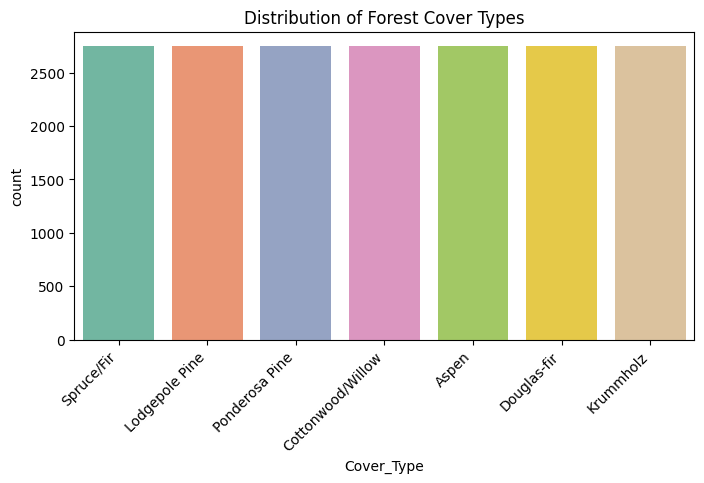

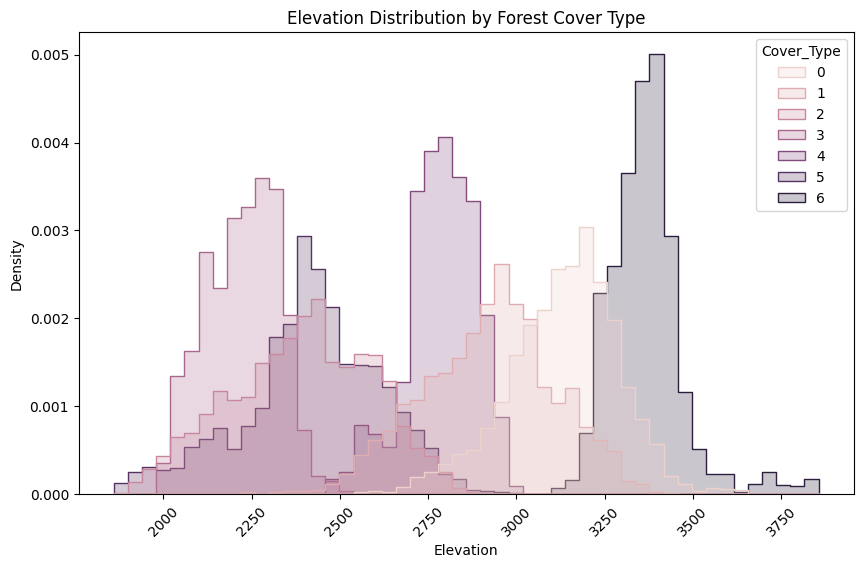

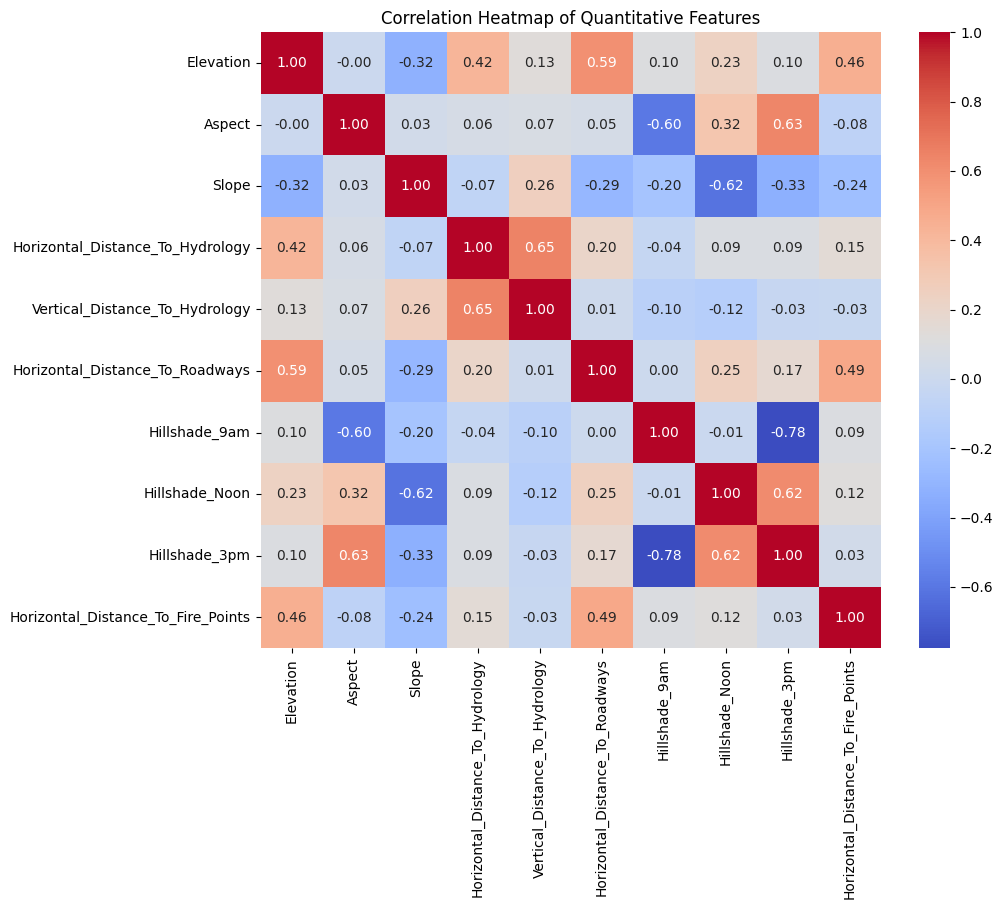

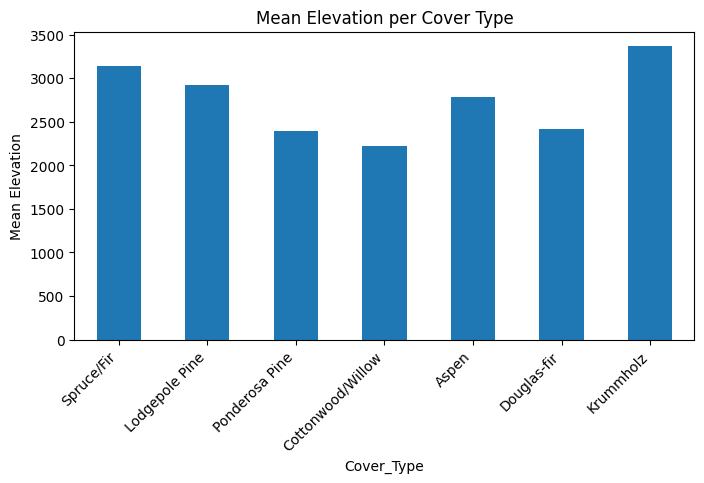

In [88]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
